<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/transfer_learning_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
### Steps involved
1. Import statements
2. Load data from `tensorflow_datasets`.
3. Split the data into training, validation and test datasets.
4. Select the pre-trained model to be used for transfer learning.
5. Pre-process the data based on the pre-processing needs of the pre-trained model.
6. Perform data augmentation.
7. Create early stopping, model checkpoint & tensorboard callbacks.
8. Setup mixe precision to speed up the training.
9. Load the pre-trained model by setting `include_top=False`
10. Create input layer
11. Pass the input through the pre-trained model and GlobalAveragePooling2D
12. Create output layer with appropriate activation function
13. Create model using `tf.keras.Model` and passing the inputs and outputs.
14. Compile the model
14. Train the model
15. plot the loss curve.
16. Evaluate the model on test dataset.
17. Unfreeze a few top layers in the base model
18. Train the model
19. Plot the loss curve
20. Evaluate the model on test dataset.

In [1]:
# 1. import
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import datetime

print(f" Tensorflow Version : {tf.__version__}")

 Tensorflow Version : 2.12.0


In [2]:
target_dataset="food101"
print(f" {target_dataset} available in Tensorflow dataset list : {target_dataset in tfds.list_builders()}")

 food101 available in Tensorflow dataset list : True


In [3]:
# 2. Download the dataset from tensorflow_datasets
dataset,info= tfds.load("food101", as_supervised=True, with_info=True)
dataset_train_size= info.splits['train'].num_examples
dataset_valid_size= info.splits['validation'].num_examples
class_names= info.features['label'].names
n_classes= info.features['label'].num_classes
dataset_train_size, dataset_valid_size, class_names[:10], n_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete6LLLW8/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete6LLLW8/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


(75750,
 25250,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [4]:
# 3. Create train , validation and test splits.
## Since the dataset may or may not contain validation and test split, lets split the training
## set into train , validation and tests.
test_set_raw, valid_set_raw, train_set_raw= tfds.load("food101"
                                                      ,split=["train[:10%]","train[10%:25%]","train[25%:]"]
                                                      ,as_supervised=True)
len(test_set_raw),len(valid_set_raw), len(train_set_raw)

(7575, 11363, 56812)

In [25]:
# 3. Create train , validation and test splits.
## Since the dataset may or may not contain validation and test split, lets split the training
## set into train , validation and tests.
(train_set, valid_set),ds_info= tfds.load("food101"
                                                      ,split=["train","validation"]
                                                      ,shuffle_files=True
                                                      ,as_supervised=True
                                                      ,with_info=True)


Let us check one image from each split

In [31]:
def display_image_and_details(test_image:None, valid_image:None, train_image:None):
  """
  The function will dispaly image in addition to the following information about image
  Image Tensor shape
  Image Label
  Image Label in String
  Args:
    test_image: tensorflow.python.data.ops.take_op._TakeDataset
    valid_image : tensorflow.python.data.ops.take_op._TakeDataset
    train_image: tensorflow.python.data.ops.take_op._TakeDataset
  Returns:
    None
  """
  gs = gridspec.GridSpec(1, 3)

  plt.figure(figsize=(15,7))
  if test_image is not None:
    for te_image,te_label in test_image:
      print(f"""
        Test Image Shape : {te_image.shape}
        Test Image dtype: {te_image.dtype}
        Test Image Label: {te_label}
        Test Image Label: {class_names[te_label]}
        Test Image max { tf.reduce_max(te_image)} and min {tf.reduce_min(te_image)}
            """)
      ax = pl.subplot(gs[0, 0])
      plt.imshow(te_image)
      plt.title(f"Test : {class_names[te_label]}")
      plt.axis(False)
  if valid_image is not None:
    for va_image,va_label in valid_image:
      print(f"""
        Valid Image Shape : {va_image.shape}
        Valid Image dtype: {va_image.dtype}
        Valid Image Label: {va_label}
        Valid Image Label: {class_names[va_label]}
        Valid Image max { tf.reduce_max(va_image)} and min {tf.reduce_min(va_image)}
            """)
      ax = pl.subplot(gs[0, 1])
      plt.imshow(va_image)
      plt.title(f"Valid : {class_names[va_label]}")
      plt.axis(False)

  if train_image is not None:
    for tr_image,tr_label in train_image:
      print(f"""
        Train Image Shape : {tr_image.shape}
        Train Image dtype: {tr_image.dtype}
        Train Image Label: {tr_label}
        Train Image Label: {class_names[tr_label]}
        Train Image max { tf.reduce_max(tr_image)} and min {tf.reduce_min(tr_image)}
            """)
      ax = pl.subplot(gs[0, 2])
      plt.imshow(tr_image)
      plt.title(f"Train : {class_names[tr_label]}")
      plt.axis(False);

 
        Test Image Shape : (512, 512, 3)
        Test Image dtype: <dtype: 'uint8'>
        Test Image Label: 56
        Test Image Label: huevos_rancheros
        Test Image max 255 and min 0
            
 
        Valid Image Shape : (512, 512, 3)
        Valid Image dtype: <dtype: 'uint8'>
        Valid Image Label: 35
        Valid Image Label: escargots
        Valid Image max 255 and min 0
            
 
        Train Image Shape : (382, 512, 3)
        Train Image dtype: <dtype: 'uint8'>
        Train Image Label: 52
        Train Image Label: gyoza
        Train Image max 255 and min 0
            


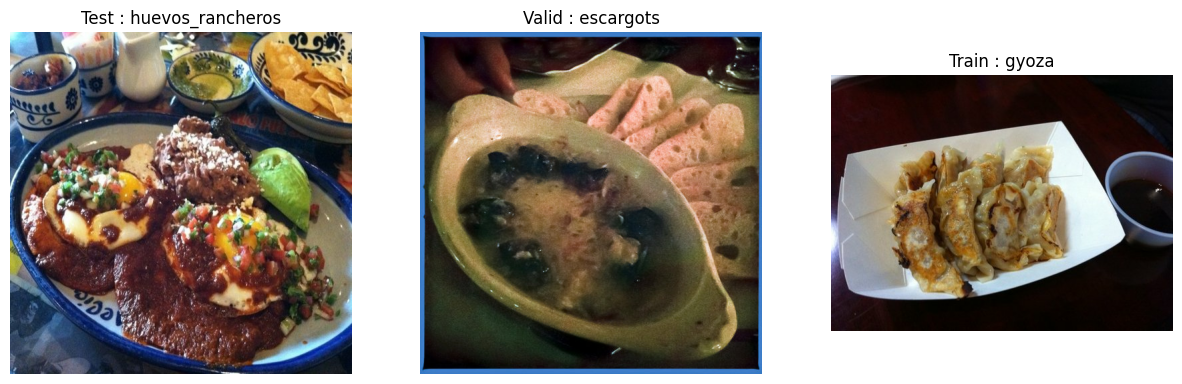

In [32]:
display_image_and_details(test_set_raw.take(1), valid_set_raw.take(1), train_set_raw.take(1))

 
        Valid Image Shape : (384, 512, 3)
        Valid Image dtype: <dtype: 'uint8'>
        Valid Image Label: 57
        Valid Image Label: hummus
        Valid Image max 255 and min 0
            
 
        Train Image Shape : (512, 512, 3)
        Train Image dtype: <dtype: 'uint8'>
        Train Image Label: 31
        Train Image Label: donuts
        Train Image max 255 and min 0
            


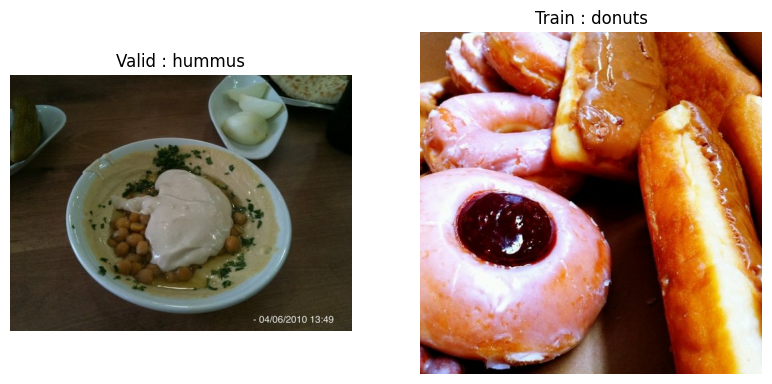

In [35]:
display_image_and_details(test_image=None
                          ,valid_image=valid_set.take(1)
                          ,train_image=train_set.take(1))

The below cell may not be reusable based on the model selection.
Every pre-trained model selected will have its specific pre-process.

In [36]:
# 4. Select a model and pre-process the data
## For our current learning we will use EfficientNetB0.
### NOTE : EfficientNetBO have a inbuilt re-scaling , hence we do not need to have re-scaling as part of pre-processing
### But as we have seen the shapes of images are not consistent, we will have to perform re-sizing
image_size=224
preprocess_img= tf.keras.Sequential([
    layers.Resizing(height=image_size,width=image_size)
])

In [37]:
# 5. Perform pre-processing
batch_size=32
train_set= train_set_raw.map(lambda X,y: (preprocess_img(X),y),num_parallel_calls=tf.data.AUTOTUNE)
train_set= train_set.shuffle(buffer_size=1000,seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set= valid_set_raw.map(lambda X,y: (preprocess_img(X),y),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#test_set= test_set_raw.map(lambda X,y: (preprocess_img(X),y),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [38]:
# uncomment this code to check if the pre-processing is correct
# for img,label in train_set.take(1):
#   print(img[0])

In [39]:
# 6. Perform data augmentation
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal")
    ,layers.RandomRotation(factor=0.2)
    ,layers.RandomContrast(factor=0.2)
    ,layers.RandomHeight(factor=0.2)
    ,layers.RandomWidth(factor=0.2)
])

In [40]:
# 7. Create early stopping, model checkpoint ,ReduceLROnPlateau tensorboard callbacks.
def create_tensorboard_callback(log_dir,experiment_name):
  log_dir= log_dir + "/" + experiment_name + "/"+datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
  print(f" Saving tensorboard logs to : {log_dir}")
  return tf.keras.callbacks.TensorBoard(log_dir)

def create_model_checkpoint(model_checkpoint_dir):
  model_checkpoint_path=f"{model_checkpoint_dir}/cp.ckpt"
  return tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path
                                            ,monitor="val_accuracy"
                                            ,save_best_only=True
                                            ,save_weights_only=True
                                            ,verbose=0)

def create_early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=3)

def create_learningrate_reducer():
  return tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss"
                                              ,patience=2
                                              ,factor=0.01
                                              ,verbose=1 # Print when the learning rate goes down
                                              ,min_lr=1e-7)

In [41]:
# 8. setup mixed precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [42]:
# 9. Load the pre-trained model by setting
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

In [43]:
# 10. Create input layer
tf.random.set_seed(42)
input_shape=(224,224,3)
inputs= layers.Input(shape=input_shape,name="input_layer")
# 11. pass the input through the base model
x= data_augmentation(inputs)
x= base_model(x,training=False)
x= layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)
# 12. Create the output layer
outputs= layers.Dense(n_classes,activation="softmax",name="output_layer")(x)
# 13. Create the model
model= tf.keras.Model(inputs=inputs
                      ,outputs=outputs
                      ,name="effnetb0_with_data_augmentation")

# 14. compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"])


In [44]:
# Create a function to plot the loss and accuracy curve

def plot_loss_curve(history):
  """
    This function will take the history object and plot the loss and accuracy
    curve for training and validation data.
  """
  epochs= range(len(history.history["loss"]))

  loss= history.history["loss"]
  val_loss= history.history["val_loss"]


  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  plt.figure(figsize=(10,7))
  plt.plot(epochs,loss, label="Train")
  plt.plot(epochs,val_loss, label="Test")
  plt.legend()
  plt.title("Loss")

  plt.figure(figsize=(10,7))
  plt.plot(epochs,accuracy, label="Train")
  plt.plot(epochs,val_accuracy, label="Test")
  plt.legend()
  plt.title("Accuracy");


In [45]:
history_effnetb0_model_1= model.fit(train_set
                                    ,steps_per_epoch=len(train_set)
                                    ,validation_data=valid_set
                                    ,validation_steps=int(0.15* len(valid_set))
                                    ,callbacks=[create_tensorboard_callback(log_dir="tensorboard_logs"
                                                                            ,experiment_name=model.name)
                                                ,create_model_checkpoint(model_checkpoint_dir="model_chkpt")
                                                ,create_early_stopping()
                                                ,create_learningrate_reducer()]
                                    ,epochs=5)

 Saving tensorboard logs to : tensorboard_logs/effnetb0_with_data_augmentation/20230812_053334
Epoch 1/5
1776/1776 [==============================] - 193s 102ms/step - loss: 2.0991 - accuracy: 0.4987 - val_loss: 1.5744 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 2/5
1776/1776 [==============================] - 175s 97ms/step - loss: 1.5362 - accuracy: 0.6077 - val_loss: 1.4814 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 3/5
1776/1776 [==============================] - 173s 95ms/step - loss: 1.3959 - accuracy: 0.6402 - val_loss: 1.4431 - val_accuracy: 0.6262 - lr: 0.0010
Epoch 4/5
1776/1776 [==============================] - 174s 96ms/step - loss: 1.3133 - accuracy: 0.6604 - val_loss: 1.4220 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 5/5
1776/1776 [==============================] - 174s 97ms/step - loss: 1.2459 - accuracy: 0.6727 - val_loss: 1.4199 - val_accuracy: 0.6474 - lr: 0.0010


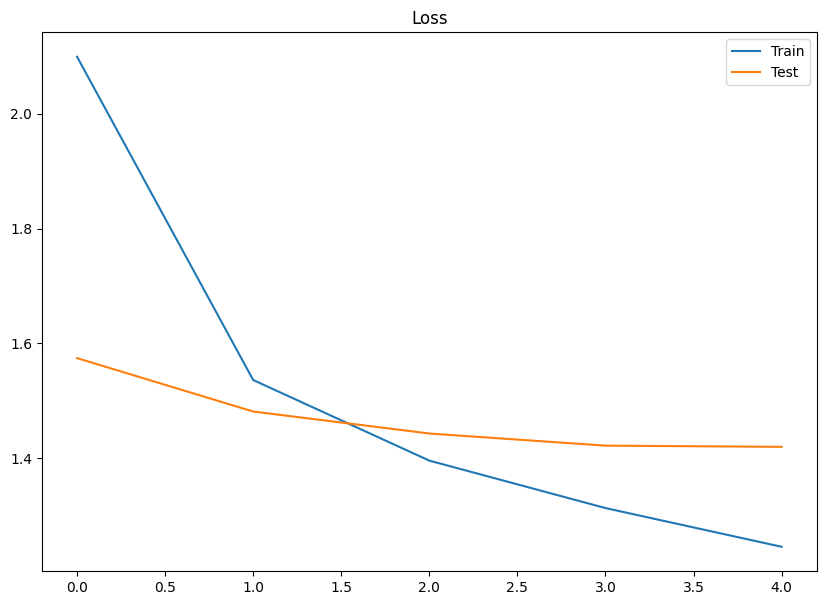

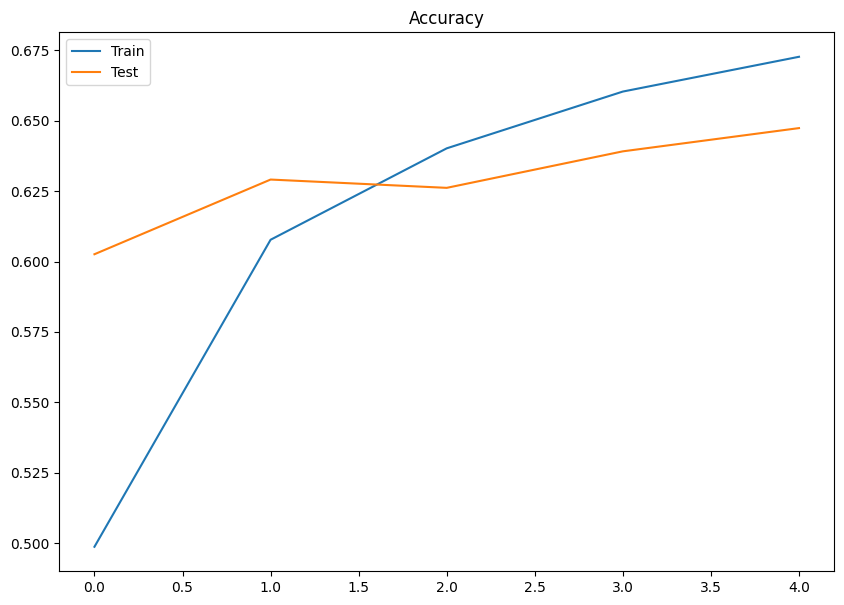

In [48]:
plot_loss_curve(history_effnetb0_model_1)

In [49]:
results_feature_extraction_model=model.evaluate(test_set)
results_feature_extraction_model

237/237 [==============================] - 22s 86ms/step - loss: 1.3857 - accuracy: 0.6459


[1.3856607675552368, 0.6459406018257141]

In [50]:
for layer in base_model.layers[56:]:
  layer.trainable= True

In [51]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"])
history_effnetb0_model_2= model.fit(train_set
                                    ,steps_per_epoch=len(train_set)
                                    ,validation_data=valid_set
                                    ,validation_steps=int(0.15 * len(valid_set))
                                    ,epochs=5
                                    ,callbacks=[
                                        create_tensorboard_callback(log_dir="tensorboard_logs",experiment_name=f"{model.name}_unfreezed_layer")
                                        ,create_model_checkpoint(model_checkpoint_dir="model_chkpt")
                                        ,create_early_stopping()
                                        ,create_learningrate_reducer()
                                        ]
                                    )

 Saving tensorboard logs to : tensorboard_logs/effnetb0_with_data_augmentation_unfreezed_layer/20230812_055334


Epoch 1/5
1487/1776 [========================>.....] - ETA: 26s - loss: 1.2074 - accuracy: 0.6805

KeyboardInterrupt: ignored

In [47]:
plot_loss_curve(history_effnetb0_model_2)

NameError: ignored